In [68]:
from functions import *
import random

In [36]:
def check_correctness(indexed_matrix):
    grid_size = indexed_matrix.shape[0]
    # Check if there are grid_size queens
    queens = np.where(indexed_matrix[:, :, 1] == 1)

    if queens[0].size != grid_size:
        return False
    # Check if there's a queen in each row
    if len(set(queens[0])) != grid_size:
        return False
    # Check if there's a queen in each column
    if len(set(queens[1])) != grid_size:
        return False
    # Check if there's a queen in 1-distance diagonal for each queen
    for i in range(grid_size):
        row, col = queens[0][i], queens[1][i]
        # Check the four possible diagonal neighbors at distance 1
        for dr, dc in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
            nr, nc = row + dr, col + dc
            if 0 <= nr < grid_size and 0 <= nc < grid_size and indexed_matrix[nr, nc, 1] == 1:
                return False  # Found a queen diagonally adjacent at distance 1
            
    # Check if each color region has at least one queen
    color_regions = {}
    
    for row in range(grid_size):
        for col in range(grid_size):
            color_index = indexed_matrix[row, col, 0]
            if color_index not in color_regions:
                color_regions[color_index] = 0
            if indexed_matrix[row, col, 1] == 1:
                color_regions[color_index] += 1
    
    # Each color region must have at least one queen
    if any(count == 0 for count in color_regions.values()):
        return False
    
    return True

In [37]:
def plot_indexed_matrix(indexed_matrix, color_dict):
    grid_size = indexed_matrix.shape[0]
    color_matrix = indexed_matrix[:, :, 0]  # Extract color indices
    
    # Create an RGB image
    rgb_image = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)
    
    for row in range(grid_size):
        for col in range(grid_size):
            color_index = color_matrix[row, col]
            rgb_image[row, col] = color_dict.get(color_index, [255, 255, 255])  # Default to white if not in dict
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the colored background
    ax.imshow(rgb_image)
    
    # Add symbols
    for row in range(grid_size):
        for col in range(grid_size):
            value = indexed_matrix[row, col, 1]
            if value == 1:  # Queen
                ax.text(col, row, '⚫', ha='center', va='center', fontsize=40, color='black')
            elif value == -1:  # Marked as X
                ax.text(col, row, 'X', ha='center', va='center', fontsize=30, color='black')

    # Set grid
    ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
    ax.tick_params(which="minor", size=0)
    
    plt.show()


In [38]:
def create_solver_dict(indexed_matrix):
    ''' Create a dict which contains for each color in the matrix the list of its cells to assign.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        solver_dict (dict): dict with the color as key and the list of its cells to assign as value.
    '''
    solver_dict = {}
    for i in range(indexed_matrix.shape[0]):
        for j in range(indexed_matrix.shape[1]):
            if indexed_matrix[i][j][1] == 0:
                if indexed_matrix[i][j][0] in solver_dict.keys():
                    solver_dict[indexed_matrix[i][j][0]].append((i, j))
                else:
                    solver_dict[indexed_matrix[i][j][0]] = [(i, j)]
    return solver_dict

In [39]:
def check_if_color_single_cell(indexed_matrix):
    ''' Check if a color has only one cell to assign.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    to_assign = []
    for elem in solver_dict.values():
        if len(elem) == 1:
            to_assign.append(elem[0])
    return to_assign

In [40]:
def check_if_row_single_cell(indexed_matrix):
    ''' Check if a row has only one cell to assign.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    to_assign = []
    row_dict = {}
    for elem in solver_dict.values():
        for cell in elem:
            if cell[0] in row_dict.keys():
                row_dict[cell[0]] += 1
            else:
                row_dict[cell[0]] = 1

    for row, count in row_dict.items():
        if count == 1:
            for cell in elem:
                if cell[0] == row:
                    to_assign.append(cell)
    return to_assign

In [41]:
def check_if_column_single_cell(indexed_matrix):
    ''' Check if a column has only one cell to assign.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    to_assign = []
    column_dict = {}
    for elem in solver_dict.values():
        for cell in elem:
            if cell[1] in column_dict.keys():
                column_dict[cell[1]] += 1
            else:
                column_dict[cell[1]] = 1
                
    for column, count in column_dict.items():
        if count == 1:
            for cell in elem:
                if cell[1] == column:
                    to_assign.append(cell)
    return to_assign

In [ ]:
def assign_empty(indexed_matrix, cell):
    ''' Assign -1 to a cell in the matrix.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
        cell (tuple): cell to assign.
    Returns:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    '''
    
    if indexed_matrix[cell[0]][cell[1]][1] == 1:
        return False # Error to handle!
    
    indexed_matrix[cell[0]][cell[1]][1] = -1
    
    return indexed_matrix

In [ ]:
def assign_queen(indexed_matrix, cell):
    ''' Assign the queen to the cell and update the state of the matrix.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
        cell (tuple): cell to assign.
    Returns:
        indexed_matrix (numpy array): updated matrix.
    '''
    grid_size = indexed_matrix.shape[0]
    # Assign the queen to the cell
    indexed_matrix[cell[0]][cell[1]][1] = 1
    # Assign -1 to all the cells in the row
    for i in range(grid_size):
        if indexed_matrix[i][cell[1]][1] == 0:
            indexed_matrix[i][cell[1]][1] = -1
        elif indexed_matrix[i][cell[1]][1] == 1:
            return False
    # Assign -1 to all the cells in the column
    for j in range(grid_size):
        if indexed_matrix[cell[0]][j][1] == 0:
            indexed_matrix[cell[0]][j][1] = -1
        elif indexed_matrix[cell[0]][j][1] == 1:
            return False
    # Assign -1 to all the cells in the diagonal
    for i in range(grid_size):
        # Check the four possible diagonal neighbors at distance 1
        for dr, dc in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
            nr, nc = cell[0] + dr, cell[1] + dc
            if 0 <= nr < grid_size and 0 <= nc < grid_size and indexed_matrix[nr, nc, 1] == 0:
                indexed_matrix[nr, nc][1] = -1
            elif 0 <= nr < grid_size and 0 <= nc < grid_size and indexed_matrix[nr, nc, 1] == 1:
                return False
    # Assign -1 to all the cells of the same color
    color = indexed_matrix[cell[0]][cell[1]][0]
    for i in range(grid_size):
        for j in range(grid_size):
            if indexed_matrix[i][j][0] == color and indexed_matrix[i][j][1] == 0:
                indexed_matrix[i][j][1] = -1
            elif indexed_matrix[i][j][0] == color and indexed_matrix[i][j][1] == 1:
                return False
    return indexed_matrix

In [44]:
def check_if_color_single_rc(indexed_matrix):
    ''' Check if a color has only one row or column to assign.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign_empty (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    unassigned_cells = [cell for elem in solver_dict.values() for cell in elem]
    grid_size = indexed_matrix.shape[0]
    to_assign_empty = []
    for elem in solver_dict.values():
        rows = []
        columns = []
        for cell in elem:
            rows.append(cell[0])
            columns.append(cell[1])
        if len(set(rows)) == 1:
            to_assign_empty.extend(list(set([(rows[0], i) for i in range(grid_size)])-set(elem)))
        if len(set(columns)) == 1:
            to_assign_empty.extend(list(set([(i, columns[0]) for i in range(grid_size)])-set(elem)))
    to_assign_empty = [x for x in to_assign_empty if x in unassigned_cells]
    return to_assign_empty

In [45]:
def check_if_rc_single_color(indexed_matrix):
    ''' Check if a row/column is populated by a single color and returns the cells of that color to assign empty.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign_empty (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    #unassigned_cells = [cell for elem in solver_dict.values() for cell in elem]
    grid_size = indexed_matrix.shape[0]
    to_assign_empty = []
    rows_dict = {i: set() for i in range(grid_size)}
    columns_dict = {i: set() for i in range(grid_size)}

    for key, elem in solver_dict.items():
        for cell in elem:
            rows_dict[cell[0]].add(key)
            columns_dict[cell[1]].add(key)
    
    for row, colors in rows_dict.items():
        if len(colors) == 1:
            to_assign_empty.extend(x for x in solver_dict[list(colors)[0]] if x[0] != row)

    for column, colors in columns_dict.items():
        if len(colors) == 1:
            to_assign_empty.extend(x for x in solver_dict[list(colors)[0]] if x[1] != column)

    #to_assign_empty = [x for x in to_assign_empty if x in unassigned_cells]
    return to_assign_empty

In [46]:
def check_if_color_corr(indexed_matrix):
    ''' Check if n rows/columns are populated by the same n colors and returns the cells of other colors in that rows/columns to assign empty
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign_empty (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    unassigned_cells = [cell for elem in solver_dict.values() for cell in elem]
    grid_size = indexed_matrix.shape[0]
    to_assign_empty = []

    colors_rows_dict = {i: set() for i in range(grid_size)}
    colors_columns_dict = {i: set() for i in range(grid_size)}

    for key, elem in solver_dict.items():
        for cell in elem:
            colors_rows_dict[key].add(cell[0])
            colors_columns_dict[key].add(cell[1])

    rows_colors_dict = {}
    columns_colors_dict = {}

    for color, rows in colors_rows_dict.items():
        if tuple(set(rows)) in rows_colors_dict.keys():
            rows_colors_dict[tuple(set(rows))].append(color)
        else:
            rows_colors_dict[tuple(set(rows))] = [color]

    for rows, colors in rows_colors_dict.items():
        if len(rows) == len(colors) and len(rows) > 1:
            to_assign_empty.extend(list(set((row, i) for row in rows for i in range(grid_size)) - set(cell for color in colors for cell in solver_dict[color])))

    for color, columns in colors_columns_dict.items():
        if tuple(set(columns)) in columns_colors_dict.keys():
            columns_colors_dict[tuple(set(columns))].append(color)
        else:
            columns_colors_dict[tuple(set(columns))] = [color]
    
    for columns, colors in columns_colors_dict.items():
        if len(columns) == len(colors) and len(columns) > 1:
            to_assign_empty.extend(list(set((i, column) for column in columns for i in range(grid_size)) - set(cell for color in colors for cell in solver_dict[color])))

    to_assign_empty = [x for x in to_assign_empty if x in unassigned_cells]
    return to_assign_empty
    

In [47]:
def check_unvalid_cells(indexed_matrix):
    ''' Check if there are cells that are not assigned and that can't be assigned to a queen.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign_empty (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    to_assign_empty = []
    initial_keys = solver_dict.keys()
    for elem in solver_dict.values():
        if len(elem) > 1:
            for cell in elem:
                test_matrix = indexed_matrix.copy()
                test_matrix = assign_queen(test_matrix, cell)
                test_solver_dict = create_solver_dict(test_matrix)
                if len(initial_keys) != len(test_solver_dict.keys())+1:
                    to_assign_empty.append(cell)
    return to_assign_empty

In [ ]:
def apply_function(f, indexed_matrix, queen=True):
    ''' Apply a function to the matrix and return the updated matrix.
    Args:
        f (function): function to apply.
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
        queen (bool): if True, the function is applied to assign a queen, otherwise an empty cell.'
    Returns:
        bool: True if the function returned a non empty list, False otherwise.
        indexed_matrix (numpy array): updated matrix.
    '''

    to_assign = f(indexed_matrix)
    if len(to_assign) == 0:
        return 0, indexed_matrix
    if queen:
        for cell in to_assign:
            indexed_matrix = assign_queen(indexed_matrix, cell)
            if indexed_matrix is False:
                return 2, indexed_matrix
    else:
        for cell in to_assign:
            indexed_matrix = assign_empty(indexed_matrix, cell)
            if indexed_matrix is False:
                return 2, indexed_matrix
    
    return 1, indexed_matrix


In [49]:
def check_if_color_corr2(indexed_matrix):
    ''' Check if n rows/columns are populated by the same n colors and returns the cells of other colors in that rows/columns to assign empty
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        to_assign_empty (list): list of the cells to assign.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    unassigned_cells = [cell for elem in solver_dict.values() for cell in elem]
    grid_size = indexed_matrix.shape[0]
    to_assign_empty = []

    colors_rows_dict = {key: set() for key in solver_dict.keys()}
    colors_columns_dict = {key: set() for key in solver_dict.keys()}

    for key, elem in solver_dict.items():
        for cell in elem:
            colors_rows_dict[key].add(cell[0])
            colors_columns_dict[key].add(cell[1])

    rows_colors_dict = {}
    columns_colors_dict = {}

    for color, rows in colors_rows_dict.items():
        if tuple(set(rows)) in rows_colors_dict.keys():
            rows_colors_dict[tuple(set(rows))].append(color)
        else:
            rows_colors_dict[tuple(set(rows))] = [color]

    rows_keys = list(rows_colors_dict.keys())
    rows_keys = sorted(rows_keys, key=len)

    for i in range(len(rows_keys)):
        for j in range(i+1, len(rows_keys)):
            if set(rows_keys[i]) - set(rows_keys[j]) == set():
                rows_colors_dict[rows_keys[j]].extend(rows_colors_dict[rows_keys[i]])
                rows_colors_dict[rows_keys[j]] = list(set(rows_colors_dict[rows_keys[j]]))

    for rows, colors in rows_colors_dict.items():
        if len(rows) == len(colors) and len(rows) > 1:
            to_assign_empty.extend(list(set((row, i) for row in rows for i in range(grid_size)) - set(cell for color in colors for cell in solver_dict[color])))

    for color, columns in colors_columns_dict.items():
        if tuple(set(columns)) in columns_colors_dict.keys():
            columns_colors_dict[tuple(set(columns))].append(color)
        else:
            columns_colors_dict[tuple(set(columns))] = [color]

    columns_keys = list(columns_colors_dict.keys())
    columns_keys = sorted(columns_keys, key=len)

    for i in range(len(columns_keys)):
        for j in range(i+1, len(columns_keys)):
            if set(columns_keys[i]) - set(columns_keys[j]) == set():
                columns_colors_dict[columns_keys[j]].extend(columns_colors_dict[columns_keys[i]])
                columns_colors_dict[columns_keys[j]] = list(set(columns_colors_dict[columns_keys[j]]))
    
    for columns, colors in columns_colors_dict.items():
        
        if len(columns) == len(colors) and len(columns) > 1:
            to_assign_empty.extend(list(set((i, column) for column in columns for i in range(grid_size)) - set(cell for color in colors for cell in solver_dict[color])))

    to_assign_empty = [x for x in to_assign_empty if x in unassigned_cells]
    return to_assign_empty
    

In [ ]:
def solver_recursive(indexed_matrix, color_dict):

    functions_queen = [check_if_color_single_cell, check_if_row_single_cell, check_if_column_single_cell]
    functions_empty = [check_if_color_single_rc, check_if_rc_single_color, check_if_color_corr2, check_unvalid_cells]
    while True:
        
        check_advance = False
        for f in functions_queen:

            res, indexed_matrix = apply_function(f, indexed_matrix)
            if res == 1:
                #print(f'Applied function {f.__name__}')
                check_advance = True
                #plot_indexed_matrix(indexed_matrix, color_dict)
            elif res == 2:
                return False
                

        for f in functions_empty:

            res, indexed_matrix = apply_function(f, indexed_matrix, queen=False)
            if res == 1:
                #print(f'Applied function {f.__name__}')
                check_advance = True
                #plot_indexed_matrix(indexed_matrix, color_dict)
            elif res == 2:
                return False
                
        if check_advance == False:
            solver_dict = create_solver_dict(indexed_matrix)
            if len(solver_dict) == 0:
                if check_correctness(indexed_matrix):
                    print('Solved!')
                else:
                    print('Not Solved!')
                break
            else:
                print('Stuck!')
                break

    return indexed_matrix

62 62
563 562


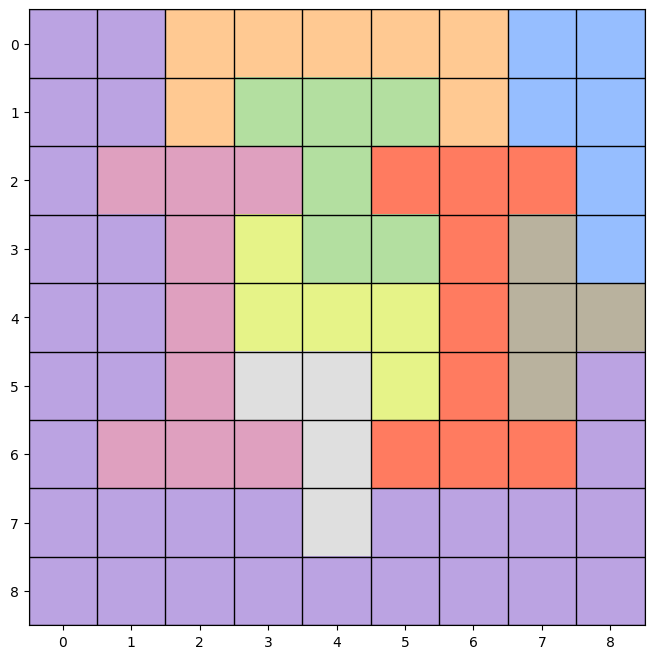

Stuck!


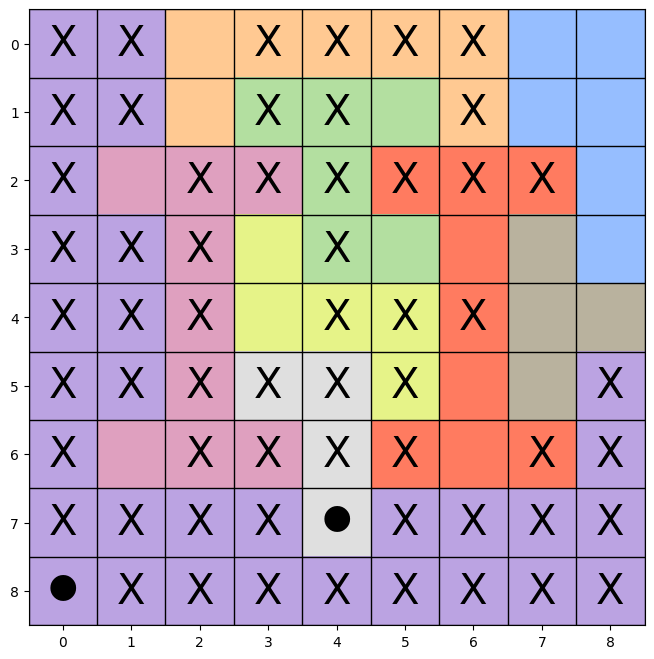

In [51]:
# Esegui il codice
image_path = "/Users/HP/Desktop/Python/queen_solver/326.png"
color_matrix = main(image_path)
plot_color_matrix(color_matrix)

indexed_matrix, color_dict = convert_color_matrix(color_matrix)
indexed_matrix = np.array([[[idx, 0] for idx in row] for row in indexed_matrix])
matrix = solver_recursive(indexed_matrix, color_dict)
plot_indexed_matrix(matrix, color_dict)

In [55]:
solver_dict = create_solver_dict(matrix)
values = solver_dict.values()
values = sorted(values, key=len)
print(values[0])

[(0, 2), (1, 2)]


In [59]:
a = 2
if a == 1:
    print(a)

In [ ]:
import random

random.shuffle(a)
print(a)

In [67]:
a = [1,2,3,4,5]
a = np.shuffle(a)
print(a)

AttributeError: module 'numpy' has no attribute 'shuffle'

In [147]:
def brute_force(indexed_matrix, color_dict):
    ''' Brute force the matrix to find a solution.
    Args:
        indexed_matrix (numpy array): matrix with the color and the state of each cell.
    Returns:
        indexed_matrix (numpy array): updated matrix.
        False if the matrix is unsolvable.
    '''
    solver_dict = create_solver_dict(indexed_matrix)
    values = solver_dict.values()
    values = sorted(values, key=len)
    values = [x for x in values if len(x) == len(values[0])]
    random.shuffle(values[0])
    for cell in values[0]:
        print(f'elem: {values[0]}, cell: {cell}')
        test_matrix = indexed_matrix.copy()
        test_matrix = assign_queen(test_matrix, cell)
        result = solver_final(test_matrix, color_dict)
        if result is not False:
            return result
    return False

def solver_final(indexed_matrix, color_dict):

    functions_queen = [check_if_color_single_cell, check_if_row_single_cell, check_if_column_single_cell]
    functions_empty = [check_if_color_single_rc, check_if_rc_single_color, check_if_color_corr2, check_unvalid_cells]
    while True:
        
        check_advance = False
        for f in functions_queen:

            res, indexed_matrix = apply_function(f, indexed_matrix)
            if res == 1:
                #print(f'Applied function {f.__name__}')
                check_advance = True
                #plot_indexed_matrix(indexed_matrix, color_dict)
            elif res == 2:
                return False
                

        for f in functions_empty:

            res, indexed_matrix = apply_function(f, indexed_matrix, queen=False)
            if res == 1:
                #print(f'Applied function {f.__name__}')
                check_advance = True
                #plot_indexed_matrix(indexed_matrix, color_dict)
            elif res == 2:
                return False
                
        if check_advance == False:
            solver_dict = create_solver_dict(indexed_matrix)
            if len(solver_dict) == 0:
                if check_correctness(indexed_matrix):
                    print('Solved!')
                else:
                    return False
                break
            else:
                indexed_matrix = brute_force(indexed_matrix, color_dict)
                if indexed_matrix is False:
                    print('Unsolvable!')
                    break
                return indexed_matrix

    return indexed_matrix

62 62
563 562


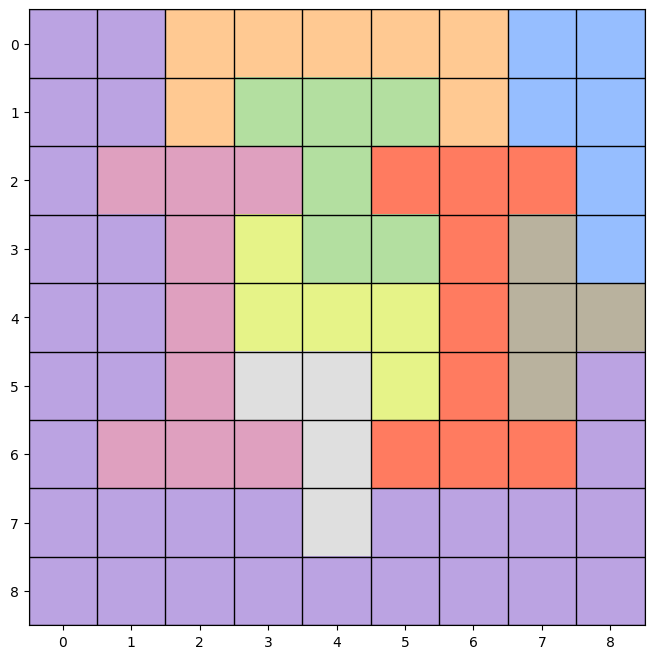

elem: [(0, 2), (1, 2)], cell: (0, 2)
elem: [(1, 5), (3, 5)], cell: (1, 5)
Solved!


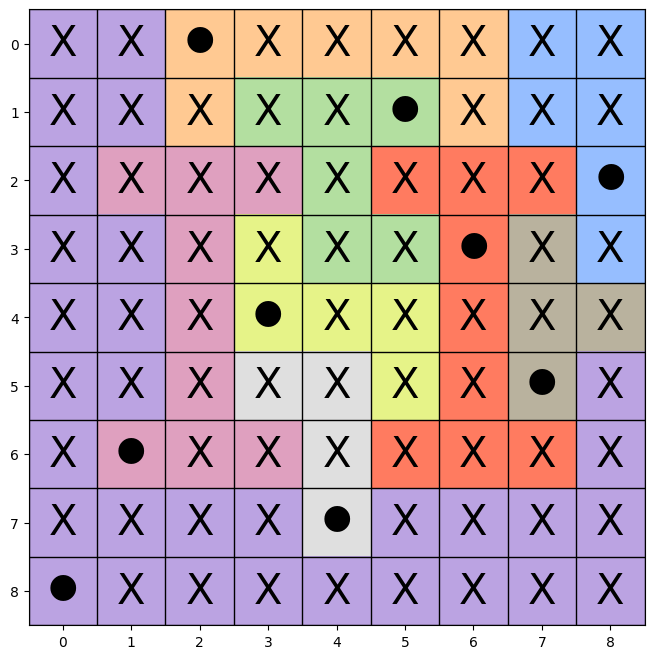

In [148]:
# Esegui il codice
image_path = "/Users/HP/Desktop/Python/queen_solver/326.png"
color_matrix = main(image_path)
plot_color_matrix(color_matrix)

indexed_matrix, color_dict = convert_color_matrix(color_matrix)
indexed_matrix = np.array([[[idx, 0] for idx in row] for row in indexed_matrix])
matrix = solver_final(indexed_matrix, color_dict)
plot_indexed_matrix(matrix, color_dict)